**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.7\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../input/69761.84.csv'
path_dump_improved = '../output/m18-improved.csv' # output solution

num_cpu_cores = 22
#time_limit = -1 # unlimited
time_limit = 6*24*60*60  # in s

occupancy_diff = 80  # +- the occupancy of input solution for each day
occupancy_diff_low = 10  # +- the occupancy of input solution for each day
max_family_rank = 6  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)
min_choice_0_families = 3742   # minimum number of families that are at their choice 0
target_pref_cost = 62868 # 62868
target_pref_cost_error = 2000
target_accounting_cost = 6020.043432 # 6020.043432
target_accounting_cost_error = 1000
max_accounting_cost = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     69761.84749677515
Preference cost: 64241
Accounting cost: 5520.847496775156


In [9]:
print(occupancy, occupancy.shape)

[125 300 285 299 300 285 263 255 253 271 296 300 297 273 262 258 273 296
 290 274 247 223 232 256 282 300 293 274 257 249 246 275 275 256 224 195
 167 192 227 251 236 206 176 153 125 294 276 252 219 188 156 125 281 260
 231 195 160 127 125 262 238 205 163 125 125 125 245 219 183 139 125 125
 125 225 206 175 128 125 127 125 229 214 181 138 126 125 125 251 231 199
 157 125 125 125 225 204 171 126 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

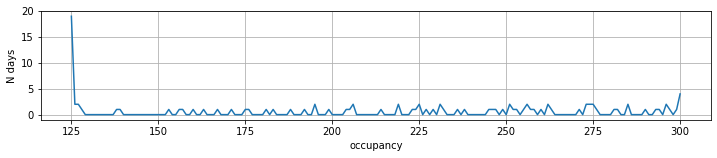

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

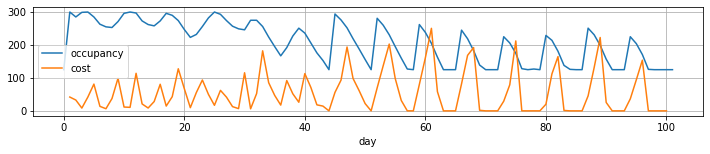

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

250.48410034179688 1       41.944504
2       32.872974
3        8.430207
4       41.944504
5       81.210869
          ...    
96     153.777359
97       0.030912
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]])

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]])

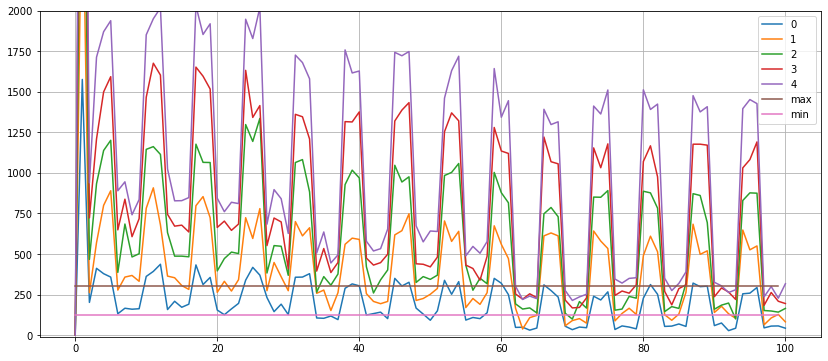

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

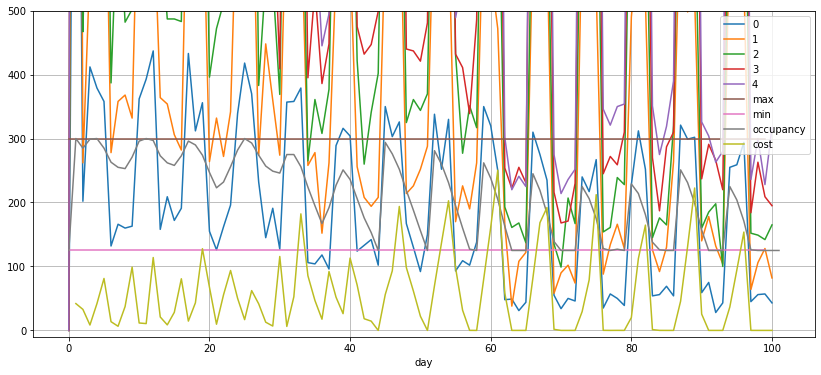

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

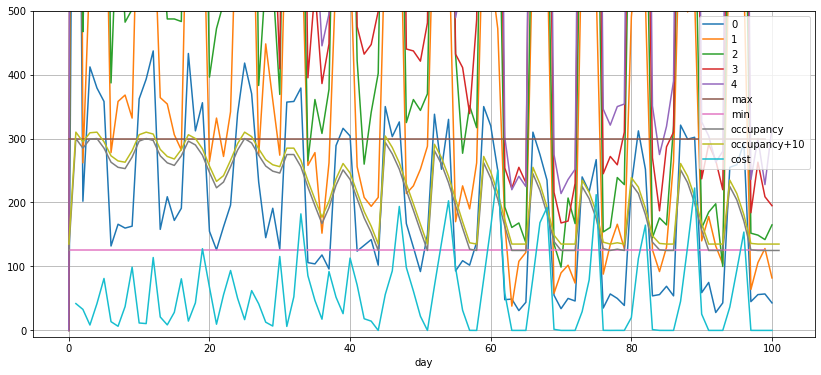

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

## Setup

In [23]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    if day == 1:
        search_occupancy[day] = [N_max_people]
    elif day == N_days:
        search_occupancy[day] = [N_min_people]
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [24]:
for i, x in search_occupancy.items():
    print(i, x)

1 [300]
2 range(205, 301)
3 range(219, 301)
4 range(220, 301)
5 range(205, 301)
6 range(183, 301)
7 range(175, 301)
8 range(173, 301)
9 range(191, 301)
10 range(216, 301)
11 range(220, 301)
12 range(217, 301)
13 range(193, 301)
14 range(182, 301)
15 range(178, 301)
16 range(193, 301)
17 range(216, 301)
18 range(210, 301)
19 range(194, 301)
20 range(167, 301)
21 range(143, 301)
22 range(152, 301)
23 range(176, 301)
24 range(202, 301)
25 range(220, 301)
26 range(213, 301)
27 range(194, 301)
28 range(177, 301)
29 range(169, 301)
30 range(166, 301)
31 range(195, 301)
32 range(195, 301)
33 range(176, 301)
34 range(144, 301)
35 range(125, 276)
36 range(125, 248)
37 range(125, 273)
38 range(147, 301)
39 range(171, 301)
40 range(156, 301)
41 range(126, 287)
42 range(125, 257)
43 range(125, 234)
44 range(125, 136)
45 range(214, 301)
46 range(196, 301)
47 range(172, 301)
48 range(139, 300)
49 range(125, 269)
50 range(125, 237)
51 range(125, 136)
52 range(201, 301)
53 range(180, 301)
54 range(151

In [25]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost

In [26]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

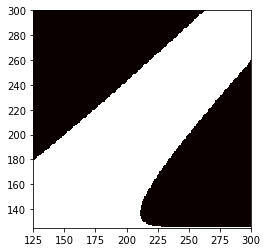

In [27]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [28]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 6


In [29]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, 136, 236, 272],
       [  0,  50,  86, 136, 236, 272],
       [  0,  50,  77, 127, 227, 254],
       ...,
       [  0,  50, 104, 154, 254, 308],
       [  0,  50,  95, 145, 245, 290],
       [  0,  50,  86, 136, 236, 272]], dtype=int64)

## DOCplex model

In [30]:
from docplex.mp.model import Model

In [31]:
solver = Model('')

In [32]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 22
Num treads: threads:int(22)
Set time limit: None


In [33]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [34]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [35]:
len(assignment_matrix)

30000

In [36]:
possible_family_sizes = np.unique(n_people)

In [37]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [38]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [39]:
search_occupancy[N_days]

[125]

In [40]:
len(occupancy_matrix)

647225

## Constraints

### constraint 1: each family only take one day (choice)

In [41]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [42]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [43]:
# constraint 2: each day can only have 125-300 people

In [44]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

6

In [45]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [46]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [47]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [48]:
for day in days:
    solver.add_range(min(search_occupancy[day]), 
                     occupancy_counts[day], 
                     max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [49]:
# constraint 3: unpreferred day family count conservation for each family size

In [50]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [51]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [52]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [53]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [54]:
# next day occupancy consistency
if True:
    # Approach 1: (faster)
    solver.add_constraints_([
        occupancy_counts[day + 1] == solver.sum([
            occupancy_matrix[day, o, o_next] * o_next 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]            
        ])
        for day in days if day < N_days
    ])
else:
    # Approach 2: (much slower)
    for day in days:
        if day + 1 < N_days:
            for o in search_occupancy[day+1]:
                solver.add_constraint_(
                    solver.sum(
                        [occupancy_matrix[day, o_other, o] for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]]
                    ) == solver.sum(
                        [occupancy_matrix[day + 1, o, o_other] for o_other in search_occupancy[day+2] if viable_nd_ndp1[o, o_other]]
                    )
                )
    for o in search_occupancy[N_days]:
        solver.add_constraint_(
            solver.sum(
                [occupancy_matrix[N_days - 1, o_other, o] for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]]
            ) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        )

### Preference cost

In [55]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [56]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        solver.add_constraints_([
            family_pref_cost <= target_pref_cost + target_pref_cost_error,
            family_pref_cost >= target_pref_cost - target_pref_cost_error
        ])
    else:
        solver.add_constraint_(family_pref_cost == target_pref_cost)

for i, (x, y) in enumerate(family_pref_cost.GetCoeffs().items()):
    if i >= 5: 
        break
    print(type(x), x, y)

family_pref_cost.GetCoeffs()[assignment_matrix[0, 1]]

### Accounting cost

In [57]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [58]:
if target_accounting_cost > 0:
    solver.add_constraints_([
        accounting_cost <= target_accounting_cost + target_accounting_cost_error,
        accounting_cost >= target_accounting_cost - target_accounting_cost_error
    ])

In [59]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [60]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [61]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

Using hint!


## Solve

In [62]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [63]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [64]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [65]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 677225 ( 677225 , 0 )
N of constraints: 5404
Time limit: 518400.0


In [66]:
%%time
# Solve
sol = solver.solve(log_output=True)

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 22
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               518400
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.06 sec. (99.03 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69761.8475.
Tried aggregator 1 time.
MIP Presolve eliminated 2 rows and 3 columns.
MIP Presolve modified 978733 coefficients.
Reduced MIP has 5400 rows, 677322 columns, and 3401122 nonzeros.
Reduced MIP has 677224 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 3.74 sec. (4342.71 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 5400 rows, 677322 columns, and 3401122 nonzeros.
Reduced MIP has 677224 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 2.95 sec. (1615.30 ticks)
Probing tim

    120    57    68880.6381   834    69761.8475    68852.3115    56826    1.30%
    123    83    68866.1629   905    69761.8475    68852.3115    88443    1.30%
    126    84    68873.7423   892    69761.8475    68852.3115    89379    1.30%
    129    88    68864.4751   904    69761.8475    68852.3115    92581    1.30%
    133    94    68867.7166   831    69761.8475    68852.3115    93583    1.30%
Elapsed time = 866.55 sec. (939352.76 ticks, tree = 7.39 MB, solutions = 1)
    136    73    68862.3269   933    69761.8475    68852.3115    79134    1.30%
    140   102    68864.2506   910    69761.8475    68852.3115   102218    1.30%
    142   102    68859.8415   915    69761.8475    68852.3115    98866    1.30%
    148    91    68864.8306   905    69761.8475    68852.3115    92084    1.30%
    151    97    68864.5639   898    69761.8475    68852.3115    96336    1.30%
    152    99    68864.3667   871    69761.8475    68852.3115    98037    1.30%
    154    99    68866.0582   896    69761.8

   1057   608    infeasible          69761.8475    68852.3115   287552    1.30%
Elapsed time = 1775.09 sec. (1245756.40 ticks, tree = 91.69 MB, solutions = 1)
   1091   653    68886.1303   622    69761.8475    68852.3115   295990    1.30%
   1122   686    68898.5849   695    69761.8475    68852.3115   309178    1.30%
   1157   591    68863.5986   918    69761.8475    68852.3115   285578    1.30%
   1195   710    68887.9763   755    69761.8475    68852.3115   315327    1.30%
   1216   691    68899.2992   694    69761.8475    68852.3115   309849    1.30%
   1234   708    68898.5765   658    69761.8475    68852.3115   312175    1.30%
   1250   711    68900.5769   641    69761.8475    68852.3115   312361    1.30%
   1273   733    68924.7917   595    69761.8475    68852.3115   319052    1.30%
   1291   701    68901.1064   671    69761.8475    68852.3115   310678    1.30%
   1316   735    68878.0041   765    69761.8475    68852.3115   323901    1.30%
Elapsed time = 1917.91 sec. (1284656.90 t

   7649  2957    infeasible          69761.8475    68852.3115   652090    1.30%
   7754  2994    68916.7705   432    69761.8475    68852.3115   655503    1.30%
   7862  3027    69041.4279   415    69761.8475    68852.3115   658820    1.30%
   7960  3148    68929.2621   470    69761.8475    68852.3115   670849    1.30%
   8041  2972    infeasible          69761.8475    68852.3115   653013    1.30%
   8120  3215    68928.7219   487    69761.8475    68852.3115   680372    1.30%
   8149  3219    68933.8367   456    69761.8475    68852.3115   680652    1.30%
   8153  2880    68867.7673   834    69761.8475    68852.3115   647100    1.30%
Elapsed time = 2978.81 sec. (1637675.08 ticks, tree = 680.84 MB, solutions = 1)
   8154  3174    68927.5276   671    69761.8475    68852.3115   680127    1.30%

Performing restart 1

Repeating presolve.
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 76558 columns.
MIP Presolve modified 512759 coefficients.
Reduced MIP has 5400 rows, 600764 colum

   9574   686    69445.6889   608    69761.8475    68879.0786   884325    1.27%
   9626   690    69411.3524   544    69761.8475    68879.0786   881533    1.27%
   9692   717    68923.6475   783    69761.8475    68879.0786   890486    1.27%
   9762   692    69702.0299   614    69761.8475    68879.0786   890565    1.27%
Elapsed time = 4694.39 sec. (3708756.82 ticks, tree = 94.40 MB, solutions = 1)
   9821   737    69478.3739   588    69761.8475    68879.0786   895590    1.27%
   9898   772    69331.9436   599    69761.8475    68879.0786   901922    1.27%
   9972   730    69582.2408   571    69761.8475    68879.0786   893929    1.27%
  10042   893    69322.7398   617    69761.8475    68879.0786   905728    1.27%
  10135   800    69573.4062   639    69761.8475    68879.0786   898091    1.27%
  10246   931    69582.6511   572    69761.8475    68879.0786   911612    1.27%
  10363   979    68941.5655   771    69761.8475    68879.0786   913622    1.27%
  10456   856    69471.2198   542    6976

Elapsed time = 5861.55 sec. (4294393.76 ticks, tree = 1018.19 MB, solutions = 1)
  15867  4378    69653.9736   494    69761.8475    68879.0786  1110976    1.27%
  15925  4504        cutoff          69761.8475    68879.0786  1115493    1.27%
  15980  4470    69605.4715   524    69761.8475    68879.0786  1113584    1.27%
  16009  4587    69714.4290   564    69761.8475    68879.0786  1117108    1.27%
  16043  4703    69605.5561   525    69761.8475    68879.0786  1118580    1.27%
  16100  4637    69657.1433   484    69761.8475    68879.0786  1118680    1.27%
  16148  4616    69715.7516   556    69761.8475    68879.0786  1117581    1.27%
  16186  4620    69716.4256   540    69761.8475    68879.0786  1117869    1.27%
  16235  4748    69605.6658   523    69761.8475    68879.0786  1118770    1.27%
  16277  4675    69667.2310   483    69761.8475    68879.0786  1119804    1.27%
Elapsed time = 5918.14 sec. (4332901.12 ticks, tree = 1082.32 MB, solutions = 1)
  16324  4880    69667.7177   469    6

  21937  8392    69735.9710   739    69761.8475    68879.0786  1208436    1.27%
  22046  8409    69735.9882   740    69761.8475    68879.0786  1208573    1.27%
  22168  8146    69704.5657   494    69761.8475    68879.0786  1201558    1.27%
  22282  8170        cutoff          69761.8475    68879.0786  1201694    1.27%
  22409  8456    69736.0650   734    69761.8475    68879.0786  1209104    1.27%
  22558  8526    69723.6925   712    69761.8475    68879.0786  1208989    1.27%
  22682  8657    69759.4249   505    69761.8475    68879.0786  1210255    1.27%
Elapsed time = 6461.55 sec. (4680931.32 ticks, tree = 2132.16 MB, solutions = 1)
Nodefile size = 67.48 MB (17.64 MB after compression)
  22811  8530    69723.7049   714    69761.8475    68879.0786  1209031    1.27%
  22890  8960    69505.4584   727    69761.8475    68879.0786  1216196    1.27%
  22992  9102        cutoff          69761.8475    68879.0786  1217408    1.27%
  23083  8907    69706.1659   484    69761.8475    68879.0786  12

  30482 13881    69730.4054   671    69761.8475    68879.0786  1304774    1.27%
  30539 13750    69514.5307   690    69761.8475    68879.0786  1294588    1.27%
  30598 13940    69730.5820   647    69761.8475    68879.0786  1305045    1.27%
  30646 13779    69514.5550   690    69761.8475    68879.0786  1294730    1.27%
  30724 13987    69730.5941   647    69761.8475    68879.0786  1305560    1.27%
  30797 14064    69606.4057   758    69761.8475    68879.0786  1314438    1.27%
  30835 14055    69514.6859   690    69761.8475    68879.0786  1310156    1.27%
  30862 13882    69725.3381   589    69761.8475    68879.0786  1310086    1.27%
  30891 13883    69725.4860   591    69761.8475    68879.0786  1310199    1.27%
  30915 14097    69514.7669   693    69761.8475    68879.0786  1310607    1.27%
Elapsed time = 7041.09 sec. (5028201.48 ticks, tree = 3568.05 MB, solutions = 1)
Nodefile size = 1486.85 MB (400.76 MB after compression)
  30928 14063    69725.8220   590    69761.8475    68879.0786 

  35234 16923    69740.2844   645    69761.8475    68879.0786  1433917    1.27%
Elapsed time = 7494.84 sec. (5338653.87 ticks, tree = 4305.54 MB, solutions = 1)
Nodefile size = 2241.77 MB (607.57 MB after compression)
  35252 17126    69724.2789   691    69761.8475    68879.0786  1438707    1.27%
  35281 16942    69742.2872   617    69761.8475    68879.0786  1434457    1.27%
  35303 16958    69742.3359   615    69761.8475    68879.0786  1434621    1.27%
  35359 16998    69742.3372   619    69761.8475    68879.0786  1434697    1.27%
  35429 17153    69633.3412   602    69761.8475    68879.0786  1446552    1.27%
  35513 17199    69725.0309   686    69761.8475    68879.0786  1439699    1.27%
  35613 17226    69725.1056   682    69761.8475    68879.0786  1439920    1.27%
  35720 17203    69715.5701   555    69761.8475    68879.0786  1451115    1.27%
  35788 17484    69725.1381   691    69761.8475    68879.0786  1454676    1.27%
  35842 17518    69725.1858   683    69761.8475    68879.0786 

  40943 21096    69335.7515   631    69761.8475    68879.0786  1568492    1.27%
  41035 21466    69722.3918   595    69761.8475    68879.0786  1581250    1.27%
  41110 21287    69677.0230   661    69761.8475    68879.0786  1568800    1.27%
  41189 21500    69723.6769   605    69761.8475    68879.0786  1581750    1.27%
Elapsed time = 8002.69 sec. (5687278.64 ticks, tree = 5503.10 MB, solutions = 1)
Nodefile size = 3408.93 MB (930.79 MB after compression)
  41252 21512    69724.9229   604    69761.8475    68879.0786  1582019    1.27%
  41322 21534    69724.9364   602    69761.8475    68879.0786  1582170    1.27%
  41397 21557    infeasible          69761.8475    68879.0786  1582349    1.27%
  41459 21908    69725.8396   620    69761.8475    68879.0786  1592964    1.27%
  41534 21929    69725.8764   617    69761.8475    68879.0786  1593137    1.27%
  41604 21782    69677.6739   647    69761.8475    68879.0786  1591666    1.27%
  41645 21971    69727.9701   624    69761.8475    68879.0786 

  46273 25507    69752.2679   674    69761.8475    68879.0786  1761860    1.27%
  46323 25539    69752.3206   675    69761.8475    68879.0786  1762156    1.27%
  46381 25400    69589.5519   740    69761.8475    68879.0786  1777900    1.27%
  46445 25408    69589.5846   740    69761.8475    68879.0786  1778110    1.27%
  46491 25633    69752.4061   673    69761.8475    68879.0786  1762864    1.27%
  46537 25665    69752.4888   671    69761.8475    68879.0786  1763146    1.27%
  46617 25699    69752.5299   673    69761.8475    68879.0786  1763361    1.27%
Elapsed time = 8603.61 sec. (6036526.97 ticks, tree = 6580.81 MB, solutions = 1)
Nodefile size = 4431.15 MB (1207.64 MB after compression)
  46732 25431    69591.4009   723    69761.8475    68879.0786  1779106    1.27%
  46840 25604    69698.7842   584    69761.8475    68879.0786  1798577    1.27%
  46950 26039    69752.6289   671    69761.8475    68879.0786  1802134    1.27%
  47026 25629    69699.7008   589    69761.8475    68879.0786

  54296 31166    69559.0602   462    69761.8475    68879.0786  1998491    1.27%
  54302 30929    69663.4110   751    69761.8475    68879.0786  1993918    1.27%
  54315 30864        cutoff          69761.8475    68879.0786  1993661    1.27%
  54344 29974    69336.1203   632    69761.8475    68879.0786  1975051    1.27%
  54375 31234    69317.8467   676    69761.8475    68879.0786  2001401    1.27%
  54415 31178    69559.7079   455    69761.8475    68879.0786  1998632    1.27%
  54427 30976    69663.4778   756    69761.8475    68879.0786  1994506    1.27%
  54438 30867    68927.6747   742    69761.8475    68879.0786  1993676    1.27%
  54461 30987    69663.5678   746    69761.8475    68879.0786  1995108    1.27%
  54488 31192    69575.1079   457    69761.8475    68879.0786  1999500    1.27%
Elapsed time = 9579.73 sec. (6383933.57 ticks, tree = 7948.78 MB, solutions = 1)
Nodefile size = 5878.50 MB (1595.21 MB after compression)
  54507 30996    69663.5794   755    69761.8475    68879.0786

  67533 41858    69752.9688   710    69761.8475    68879.0786  2354254    1.27%
Elapsed time = 11640.84 sec. (7165177.66 ticks, tree = 10854.05 MB, solutions = 1)
Nodefile size = 8776.04 MB (2368.35 MB after compression)
  67973 41945    69755.2999   680    69761.8475    68879.0786  2355798    1.27%
  68241 41922    69657.0604   588    69761.8475    68879.0786  2354375    1.27%
  68357 41465    68915.8241   757    69761.8475    68879.0786  2352625    1.27%
  68507 42314    69509.7135   579    69761.8475    68879.0786  2382233    1.27%
  68794 42372    69510.2373   587    69761.8475    68879.0786  2382873    1.27%
  69205 42584    69550.5483   669    69761.8475    68879.0786  2387995    1.27%
  69611 42560    69680.2943   557    69761.8475    68879.0786  2396512    1.27%
  70088 42766    69662.0198   726    69761.8475    68879.0786  2419127    1.27%
  70640 42848    69746.2774   615    69761.8475    68879.0786  2414535    1.27%
  71060 42960    infeasible          69761.8475    68879.07

  92345     3    68882.2382  1000    69761.8475    68882.2385  3091096    1.26%
  92347     3    68882.2386  1000    69761.8475    68882.2412  3091259    1.26%
  92348     3    68882.4629   974    69761.8475    68882.4635  3091953    1.26%
  92350     4    68882.4978   970    69761.8475    68882.4982  3092011    1.26%
Elapsed time = 20910.84 sec. (13516039.56 ticks, tree = 0.21 MB, solutions = 1)
  92352     4    68882.5156   976    69761.8475    68882.5158  3092497    1.26%
  92354     4    68882.5217   973    69761.8475    68882.5217  3093494    1.26%
  92357     2        cutoff          69761.8475    68882.5281  3094208    1.26%
  92358     4    68882.5281   975    69761.8475    68882.5282  3093949    1.26%
  92361     4    68882.5295   975    69761.8475    68882.5302  3094219    1.26%
  92364     2        cutoff          69761.8475    68882.5358  3096899    1.26%
  92368     3        cutoff          69761.8475    68882.5423  3102599    1.26%
  92372     4        cutoff          697

Elapsed time = 22993.88 sec. (15243446.40 ticks, tree = 39.04 MB, solutions = 1)
  94778   390    69728.5478   563    69761.8475    68882.7211  3309926    1.26%
  94858   413    69364.8841   567    69761.8475    68882.7211  3308082    1.26%
  94936   425    69446.2944   583    69761.8475    68882.7211  3322341    1.26%
  95011   426    69446.4427   594    69761.8475    68882.7211  3322469    1.26%
  95101   525    69737.6179   554    69761.8475    68882.7211  3330418    1.26%
  95200   492    69688.9650   535    69761.8475    68882.7211  3327010    1.26%
  95306   481    69391.4744   539    69761.8475    68882.7211  3325357    1.26%
  95406   597    69405.4154   551    69761.8475    68882.7211  3336482    1.26%
  95510   671    69729.2421   548    69761.8475    68882.7211  3342885    1.26%
  95622   594    69447.2307   585    69761.8475    68882.7211  3337141    1.26%
Elapsed time = 23340.20 sec. (15397782.86 ticks, tree = 75.65 MB, solutions = 1)
  95743   614    69407.4024   530    6

 106738  6121    69417.3409   546    69761.8475    68882.8222  3734407    1.26%
 106893  6316    68983.1032   660    69761.8475    68882.8222  3747134    1.26%
 107048  6267    69402.7764   558    69761.8475    68882.8222  3735094    1.26%
 107202  6658    69715.1390   493    69761.8475    68882.8222  3764685    1.26%
 107355  6375    69705.1854   487    69761.8475    68882.8222  3760356    1.26%
 107512  6752    69713.8917   529    69761.8475    68882.8222  3773163    1.26%
 107669  6664    69715.2429   497    69761.8475    68882.8222  3765154    1.26%
Elapsed time = 25768.64 sec. (16781260.33 ticks, tree = 1548.87 MB, solutions = 1)
 107821  6921    69402.8816   563    69761.8475    68882.8222  3781270    1.26%
 107971  6999    69452.7745   538    69761.8475    68882.8222  3781558    1.26%
 108127  7113    69402.8011   558    69761.8475    68882.8222  3782076    1.26%
 108295  7127    69309.3824   581    69761.8475    68882.8222  3789763    1.26%
 108461  7128    69739.3092   639    

 121708 15391    69453.9809   546    69761.8475    68882.8222  4100023    1.26%
 121880 15827    69749.8255   493    69761.8475    68882.8222  4124577    1.26%
 122056 16014    69202.8409   567    69761.8475    68882.8222  4134544    1.26%
 122221 15972    69549.5376   511    69761.8475    68882.8222  4124702    1.26%
 122386 16228    69455.4969   535    69761.8475    68882.8222  4135879    1.26%
 122561 16273    69693.8459   498    69761.8475    68882.8222  4138829    1.26%
 122723 15915    69734.0887   621    69761.8475    68882.8222  4134119    1.26%
 122898 16558    69750.8549   496    69761.8475    68882.8222  4158445    1.26%
Elapsed time = 27939.50 sec. (18162307.02 ticks, tree = 4049.65 MB, solutions = 1)
Nodefile size = 1990.27 MB (498.32 MB after compression)
 123082 16335        cutoff          69761.8475    68882.8222  4139392    1.26%
 123262 16703    69407.3466   564    69761.8475    68882.8222  4167261    1.26%
 123450 16999    69421.2396   531    69761.8475    68882.822

Nodefile size = 4525.40 MB (1125.80 MB after compression)
 137531 27149    69411.0180   556    69761.8475    68882.8606  4568362    1.26%
 137679 27387    69108.1049   766    69761.8475    68882.8606  4578679    1.26%
 137822 27167    69411.0249   556    69761.8475    68882.8606  4568391    1.26%
 137982 27073    69729.3248   655    69761.8475    68882.8606  4561722    1.26%
 138153 27724    69553.2732   518    69761.8475    68882.8606  4583487    1.26%
 138329 27534    69620.8086   515    69761.8475    68882.8606  4580165    1.26%
 138501 27750    69553.3266   517    69761.8475    68882.8606  4583653    1.26%
 138677 27641    69501.1329   532    69761.8475    68882.8606  4583131    1.26%
 138854 28272    69457.6796   528    69761.8475    68882.8606  4610016    1.26%
 139035 27793    69553.4554   506    69761.8475    68882.8606  4583796    1.26%
Elapsed time = 29969.63 sec. (19542464.71 ticks, tree = 6894.11 MB, solutions = 1)
Nodefile size = 4804.19 MB (1195.13 MB after compression)
 

 153843 39611    69371.6716   566    69761.8475    68882.8665  4911154    1.26%
 154031 40381    69722.3978   508    69761.8475    68882.8665  4928867    1.26%
Elapsed time = 31718.78 sec. (20768636.23 ticks, tree = 10086.45 MB, solutions = 1)
Nodefile size = 8019.48 MB (1998.92 MB after compression)
 154229 40132    69557.6672   493    69761.8475    68882.8665  4925795    1.26%
 154431 39637    69371.6825   566    69761.8475    68882.8665  4911228    1.26%
 154641 39807    69475.5604   531    69761.8475    68882.8665  4911984    1.26%
 154854 39958    69715.6690   586    69761.8475    68882.8665  4928402    1.26%
 155070 39840    69475.5669   541    69761.8475    68882.8665  4912055    1.26%
 155287 41051    69371.7586   564    69761.8475    68882.8665  4947997    1.26%
 155508 40751    69684.7312   665    69761.8475    68882.8665  4939228    1.26%
 155725 40595    69743.7159   607    69761.8475    68882.8665  4934403    1.26%
 155935 41077    69371.8381   558    69761.8475    68882.8

 170791 52850    69398.4976   545    69761.8475    68882.8665  5181496    1.26%
 170958 53280    69408.8682   536    69761.8475    68882.8665  5183923    1.26%
 171130 52655    69627.9504   498    69761.8475    68882.8665  5161073    1.26%
 171295 53743    69463.5518   493    69761.8475    68882.8665  5190796    1.26%
 171472 54399    69329.3947   685    69761.8475    68882.8665  5195735    1.26%
Elapsed time = 33627.61 sec. (22149991.40 ticks, tree = 13639.97 MB, solutions = 1)
Nodefile size = 11566.97 MB (2883.05 MB after compression)
 171653 54345    69627.9944   495    69761.8475    68882.8665  5194140    1.26%
 171834 54586    69450.6604   675    69761.8475    68882.8665  5199256    1.26%
 172009 53488    69688.3047   666    69761.8475    68882.8665  5185899    1.26%
 172197 54114    69477.6068   510    69761.8475    68882.8665  5192920    1.26%
 172376 54208    69506.9923   499    69761.8475    68882.8665  5193506    1.26%
 172550 55123    69688.3963   671    69761.8475    68882.

 186935 67904    69466.4329   493    69761.8475    68882.8665  5380080    1.26%
 187113 67409    68927.4844   770    69761.8475    68882.8665  5372432    1.26%
 187288 69125    69401.7989   543    69761.8475    68882.8665  5402389    1.26%
 187454 68112    69375.6528   563    69761.8475    68882.8665  5380744    1.26%
 187619 67938    69466.6551   496    69761.8475    68882.8665  5380277    1.26%
 187793 69150    69401.8120   544    69761.8475    68882.8665  5402471    1.26%
 187967 69262    69115.0317   741    69761.8475    68882.8665  5402695    1.26%
 188149 69167    69401.8183   545    69761.8475    68882.8665  5402541    1.26%
Elapsed time = 35514.26 sec. (23530383.57 ticks, tree = 17390.36 MB, solutions = 1)
Nodefile size = 15304.62 MB (3784.90 MB after compression)
 188326 69719    69655.9556   720    69761.8475    68882.8665  5422703    1.26%
 188491 67981    69466.6730   496    69761.8475    68882.8665  5380383    1.26%
 188661 69091    68893.8730   782    69761.8475    68882.

Nodefile size = 18028.34 MB (4432.67 MB after compression)
 202379 81818    69734.1447   461    69761.8475    68882.8665  5623648    1.26%
 202560 81670    69517.3058   475    69761.8475    68882.8665  5612441    1.26%
 202753 81568    69330.2151   679    69761.8475    68882.8665  5610952    1.26%
 202928 82560    69653.2999   505    69761.8475    68882.8665  5640505    1.26%
 203113 82013    69422.4991   501    69761.8475    68882.8665  5631467    1.26%
 203301 81912    68894.1696   773    69761.8475    68882.8665  5617754    1.26%
 203495 82504        cutoff          69761.8475    68882.8665  5640390    1.26%
 203669 81909    69374.9105   760    69761.8475    68882.8665  5632352    1.26%
 203849 82517    69633.6388   559    69761.8475    68882.8665  5641174    1.26%
 204036 83112    69482.6467   464    69761.8475    68882.8665  5642932    1.26%
Elapsed time = 37419.38 sec. (24910655.97 ticks, tree = 20927.52 MB, solutions = 1)
Nodefile size = 18836.15 MB (4627.62 MB after compression

 219008 95987    69574.8468   502    69761.8475    68882.8665  5838027    1.26%
 219224 95425    69487.3283   484    69761.8475    68882.8665  5828514    1.26%
Elapsed time = 39108.09 sec. (26138230.41 ticks, tree = 24109.54 MB, solutions = 1)
Nodefile size = 21995.27 MB (5379.58 MB after compression)
 219434 97258    69595.9056   518    69761.8475    68882.8665  5866540    1.26%
 219633 95166    69379.5580   533    69761.8475    68882.8665  5827424    1.26%
 219827 96989    69703.1619   520    69761.8475    68882.8665  5861162    1.26%
 220021 95970    69335.4868   664    69761.8475    68882.8665  5833795    1.26%
 220206 97517    69473.7193   450    69761.8475    68882.8665  5867828    1.26%
 220390 97027    69703.3407   521    69761.8475    68882.8665  5861736    1.26%
 220567 96881    69116.4993   724    69761.8475    68882.8665  5858030    1.26%
 220736 97875    69488.2305   460    69761.8475    68882.8665  5870137    1.26%
 220886 96732    69428.8468   470    69761.8475    68882.

 239525 112378    68895.0829   750    69761.8475    68883.0234  6294760    1.26%
 239668 113575    69620.3059   683    69761.8475    68883.0234  6347695    1.26%
 239804 113431    69531.6551   679    69761.8475    68883.0234  6338257    1.26%
 239945 113851    69499.7657   432    69761.8475    68883.0234  6348950    1.26%
 240072 114101    69435.7182   439    69761.8475    68883.0234  6403411    1.26%
 240213 114112    69435.7186   439    69761.8475    68883.0234  6403422    1.26%
Elapsed time = 41818.67 sec. (27518461.41 ticks, tree = 28950.81 MB, solutions = 1)
Nodefile size = 26856.87 MB (6544.93 MB after compression)
 240360 114385    68895.0834   748    69761.8475    68883.0234  6410125    1.26%
 240520 114395    68895.0834   749    69761.8475    68883.0234  6410139    1.26%
 240677 115253        cutoff          69761.8475    68883.0234  6481414    1.26%
 240834 115249    69656.5988   540    69761.8475    68883.0234  6504194    1.26%
 240997 114635    69138.8369   682    69761.847

Nodefile size = 29788.86 MB (7285.14 MB after compression)
 255478 125481    69701.7743   466    69761.8475    68883.0234  6875576    1.26%
 255656 124740    69532.7564   669    69761.8475    68883.0234  6862773    1.26%
 255845 125166    69699.1353   490    69761.8475    68883.0234  6863322    1.26%
 256007 124486    69718.1280   501    69761.8475    68883.0234  6853168    1.26%
 256188 126168    69359.1543   734    69761.8475    68883.0234  6896923    1.26%
 256374 126012        cutoff          69761.8475    68883.0234  6899149    1.26%
 256559 126994    69699.5777   490    69761.8475    68883.0234  6936887    1.26%
 256752 126534    69532.8150   662    69761.8475    68883.0234  6933307    1.26%
 256942 126834    69577.2937   670    69761.8475    68883.0234  6934542    1.26%
 257115 125877    69139.1497   675    69761.8475    68883.0234  6880700    1.26%
Elapsed time = 43887.23 sec. (28898794.87 ticks, tree = 31983.96 MB, solutions = 1)
Nodefile size = 29873.30 MB (7305.73 MB after c

 271767 137937    69740.1155   532    69761.8475    68883.0234  7320750    1.26%
 271944 136378    68892.3783   856    69761.8475    68883.0234  7272336    1.26%
 272131 137900        cutoff          69761.8475    68883.0234  7303828    1.26%
Elapsed time = 45708.20 sec. (30125197.55 ticks, tree = 35082.38 MB, solutions = 1)
Nodefile size = 32993.93 MB (8081.39 MB after compression)
 272324 138023    69537.2947   551    69761.8475    68883.0234  7325969    1.26%
 272524 137585    69730.7818   503    69761.8475    68883.0234  7297961    1.26%
 272726 138856    69705.6644   487    69761.8475    68883.0234  7361074    1.26%
 272923 138982    69463.7332   693    69761.8475    68883.0234  7361856    1.26%
 273114 137540    69139.6409   635    69761.8475    68883.0234  7284230    1.26%
 273308 137808    69608.7449   532    69761.8475    68883.0234  7297753    1.26%
 273480 137951    69641.1072   625    69761.8475    68883.0234  7305519    1.26%
 273654 138546    68892.3833   855    69761.847

 286570 148088    69690.2193   525    69761.8475    68883.0234  7743010    1.26%
 286732 148654    69490.7017   556    69761.8475    68883.0234  7796883    1.26%
 286894 150170    69604.4430   534    69761.8475    68883.0234  7849167    1.26%
 287052 148673    69490.7171   559    69761.8475    68883.0234  7797128    1.26%
 287211 150190    69604.5236   529    69761.8475    68883.0234  7849405    1.26%
 287371 149664    69370.2458   563    69761.8475    68883.0234  7836214    1.26%
 287538 149389    69550.3798   555    69761.8475    68883.0234  7822774    1.26%
Elapsed time = 47919.45 sec. (31506343.56 ticks, tree = 38061.95 MB, solutions = 1)
Nodefile size = 35966.26 MB (8853.76 MB after compression)
 287706 149939    69690.6148   518    69761.8475    68883.0234  7837528    1.26%
 287860 150233    69604.6713   531    69761.8475    68883.0234  7849724    1.26%
 288031 149960    69690.6718   517    69761.8475    68883.0234  7837645    1.26%
 288206 149644    69580.2329   558    69761.847

Nodefile size = 38794.26 MB (9583.19 MB after compression)
 301085 160676    69739.2959   545    69761.8475    68883.2281  8386813    1.26%
 301236 160187    69753.5698   509    69761.8475    68883.2281  8337117    1.26%
 301387 159589    69375.3123   558    69761.8475    68883.2281  8290536    1.26%
 301535 160463    69690.7753   557    69761.8475    68883.2281  8353887    1.26%
 301688 160629    69638.6393   680    69761.8475    68883.2281  8364037    1.26%
 301841 160949    69439.6203   576    69761.8475    68883.2281  8388010    1.26%
 302000 160435    69552.2750   556    69761.8475    68883.2281  8351260    1.26%
 302162 160972    69439.6317   572    69761.8475    68883.2281  8388148    1.26%
 302328 160692    69747.0933   540    69761.8475    68883.2281  8392404    1.26%
 302491 160994    69439.6347   573    69761.8475    68883.2281  8388230    1.26%
Elapsed time = 50100.16 sec. (32888688.83 ticks, tree = 41083.11 MB, solutions = 1)
Nodefile size = 38978.94 MB (9631.90 MB after c

 315800 169883    69376.6688   522    69761.8475    68883.2281  8824671    1.26%
 315973 171303    69639.6120   659    69761.8475    68883.2281  8887882    1.26%
 316164 170882    69695.4410   507    69761.8475    68883.2281  8867424    1.26%
Elapsed time = 52107.03 sec. (34115971.82 ticks, tree = 43649.55 MB, solutions = 1)
Nodefile size = 41559.36 MB (10296.60 MB after compression)
 316346 170313    69534.2512   574    69761.8475    68883.2281  8835135    1.26%
 316534 170639    69757.6856   516    69761.8475    68883.2281  8868503    1.26%
 316718 171455    69519.9204   575    69761.8475    68883.2281  8907643    1.26%
 316907 171817    69376.6902   521    69761.8475    68883.2281  8921644    1.26%
 317085 171424    68886.7338   851    69761.8475    68883.2281  8907519    1.26%
 317252 171457    69738.9108   483    69761.8475    68883.2281  8918247    1.26%
 317421 171519        cutoff          69761.8475    68883.2281  8920545    1.26%
 317602 172424    69758.2381   506    69761.84

 330336 176743    69714.4426   539    69732.5984    68883.5416  9333765    1.22%
 330505 176752    69714.4440   537    69732.5984    68883.5416  9333808    1.22%
 330685 176544    69549.0669   566    69732.5984    68883.5416  9319434    1.22%
 330862 177886    68883.9437   879    69732.5984    68883.5416  9344818    1.22%
 331032 178368    69699.5106   571    69732.5984    68883.5416  9368725    1.22%
 331208 177506    69377.9415   510    69732.5984    68883.5416  9342312    1.22%
 331388 177191    69342.6860   679    69732.5984    68883.5416  9337865    1.22%
 331558 178958    69633.6002   656    69732.5984    68883.5416  9381960    1.22%
 331731 179233    69603.3256   675    69732.5984    68883.5416  9396051    1.22%
Elapsed time = 54244.36 sec. (35497664.12 ticks, tree = 45780.33 MB, solutions = 2)
Nodefile size = 43701.22 MB (10861.41 MB after compression)
 331907 177551    69377.9540   506    69732.5984    68883.5416  9342469    1.22%
 332087 177638    69600.0122   573    69732.59

 345831 190924    69494.1633   550    69732.5984    68883.5416  9683721    1.22%
 345993 189843    69663.0708   559    69732.5984    68883.5416  9655770    1.22%
Elapsed time = 55964.39 sec. (36725224.01 ticks, tree = 48511.44 MB, solutions = 2)
Nodefile size = 46432.96 MB (11633.25 MB after compression)
 346162 190183    68887.8450   828    69732.5984    68883.5416  9651029    1.22%
 346337 190741    69650.2137   562    69732.5984    68883.5416  9684155    1.22%
 346516 190747    69654.4222   548    69732.5984    68883.5416  9679782    1.22%
 346695 191010    69600.8043   570    69732.5984    68883.5416  9683886    1.22%
 346866 190992    69494.4299   549    69732.5984    68883.5416  9684100    1.22%
 347031 191480    69694.4386   600    69732.5984    68883.5416  9706845    1.22%
 347206 191788    69570.4784   662    69732.5984    68883.5416  9711041    1.22%
 347381 191034    69600.8106   571    69732.5984    68883.5416  9683954    1.22%
 347566 192132    69551.7646   535    69732.59

 361099 202694    69571.1572   676    69732.5984    68883.7139 10027809    1.22%
 361272 203081    69557.2695   557    69732.5984    68883.7139 10033113    1.22%
 361443 201657    69705.6205   532    69732.5984    68883.7139 10004414    1.22%
 361618 202266    69075.2969   753    69732.5984    68883.7139 10020622    1.22%
 361798 202478    68884.4042   852    69732.5984    68883.7139 10023312    1.22%
 361987 203994    69496.4966   517    69732.5984    68883.7139 10055062    1.22%
Elapsed time = 57896.51 sec. (38104517.11 ticks, tree = 52148.36 MB, solutions = 2)
Nodefile size = 50067.88 MB (12646.13 MB after compression)
 362185 203256    69043.9870   738    69732.5984    68883.7139 10041561    1.22%
 362370 203221    69672.4081   553    69732.5984    68883.7139 10036854    1.22%
 362555 202554    69694.6837   491    69732.5984    68883.7139 10027879    1.22%
 362746 203858    69050.0946   724    69732.5984    68883.7139 10053746    1.22%
 362919 202529    68884.4203   857    69732.59

Nodefile size = 52510.71 MB (13292.51 MB after compression)
 376163 215608    69653.1987   559    69732.5984    68883.7160 10445781    1.22%
 376336 215689    69626.7752   530    69732.5984    68883.7160 10455333    1.22%
 376492 214720    68888.3584   793    69732.5984    68883.7160 10399521    1.22%
 376649 215483    69498.1795   540    69732.5984    68883.7160 10443603    1.22%
 376811 216728    69376.7743   555    69732.5984    68883.7160 10470203    1.22%
 376975 214975    69636.0923   638    69732.5984    68883.7160 10411552    1.22%
 377145 215268    69337.6165   558    69732.5984    68883.7160 10448320    1.22%
 377335 214911    69575.4806   603    69732.5984    68883.7160 10406135    1.22%
 377540 215261    69050.5667   745    69732.5984    68883.7160 10437468    1.22%
 377736 216619    69410.5776   685    69732.5984    68883.7160 10469031    1.22%
Elapsed time = 59957.56 sec. (39484956.62 ticks, tree = 55419.53 MB, solutions = 2)
Nodefile size = 53321.32 MB (13508.42 MB after

 390661 226362    69684.1456   489    69732.5984    68883.7160 10891663    1.22%
 390814 228163    69405.9619   580    69732.5984    68883.7160 10961322    1.22%
 390966 228012    68889.3144   787    69732.5984    68883.7160 10947312    1.22%
Elapsed time = 61934.28 sec. (40713667.50 ticks, tree = 58389.36 MB, solutions = 2)
Nodefile size = 56294.46 MB (14285.96 MB after compression)
 391133 227727    69641.3664   548    69732.5984    68883.7160 10934284    1.22%
 391309 227000    69718.2458   481    69732.5984    68883.7160 10917326    1.22%
 391478 228043    68889.3210   782    69732.5984    68883.7160 10947439    1.22%
 391641 228571    69607.1070   585    69732.5984    68883.7160 10998610    1.22%
 391820 228211    69309.7255   680    69732.5984    68883.7160 10970082    1.22%
 392001 228415    69579.1077   583    69732.5984    68883.7160 10970087    1.22%
 392186 229207    69623.0764   565    69732.5984    68883.7160 11039444    1.22%
 392371 229371    69687.5777   541    69732.59

 404671 238316    69626.8702   526    69712.4200    68883.8871 11470171    1.19%
 404851 238358    69713.2996   459    69712.4200    68883.8871 11475431    1.19%
 405020 233267    69034.4036   787    69712.4200    68883.8871 11499390    1.19%
 405171 233614    69394.2241   516    69712.4200    68883.8871 11510645    1.19%
 405324 232952    69680.1618   540    69712.4200    68883.8871 11500720    1.19%
 405471 234002    69583.4556   497    69712.4200    68883.8871 11517001    1.19%
 405627 238817    69446.5139   568    69712.4200    68883.8871 11496684    1.19%
 405780 233756    69053.1205   725    69712.4200    68883.8871 11511634    1.19%
 405937 233764    69053.1222   728    69712.4200    68883.8871 11511671    1.19%
Elapsed time = 64160.26 sec. (42094298.32 ticks, tree = 59875.86 MB, solutions = 3)
Nodefile size = 57779.11 MB (14667.65 MB after compression)
 406094 234870    69658.8949   537    69712.4200    68883.8871 11549605    1.19%
 406252 234872    69659.0927   540    69712.42

 420579 245170    69439.2579   567    69712.4200    68883.9824 12058615    1.19%
 420798 244292    69617.6180   581    69712.4200    68883.9824 12035509    1.19%
Elapsed time = 66058.45 sec. (43322062.45 ticks, tree = 62622.80 MB, solutions = 3)
Nodefile size = 60508.82 MB (15380.49 MB after compression)
 421006 245450    69695.1012   540    69712.4200    68883.9824 12097945    1.19%
 421200 245459    69695.5504   548    69712.4200    68883.9824 12098675    1.19%
 421395 246013    69608.3784   505    69712.4200    68883.9824 12101980    1.19%
 421584 245178    69140.8528   715    69712.4200    68883.9824 12047114    1.19%
 421766 245482    69696.5672   537    69712.4200    68883.9824 12100584    1.19%
 421961 245487    69696.7898   537    69712.4200    68883.9824 12101131    1.19%
 422151 247171    69053.9921   776    69712.4200    68883.9824 12120084    1.19%
 422341 246193    69588.7587   560    69712.4200    68883.9824 12107534    1.19%
 422548 245469    69582.6871   562    69712.42

 436029 258601    69635.6702   566    69712.4200    68884.1040 12651907    1.19%
 436208 256900    69592.7727   503    69712.4200    68884.1040 12559868    1.19%
 436397 259432    69397.0224   618    69712.4200    68884.1040 12687464    1.19%
 436586 258881    69617.9183   563    69712.4200    68884.1040 12655126    1.19%
 436777 258913    69662.2222   557    69712.4200    68884.1040 12659643    1.19%
 436971 258905    69618.1103   562    69712.4200    68884.1040 12655438    1.19%
Elapsed time = 68200.83 sec. (44701602.13 ticks, tree = 66436.51 MB, solutions = 3)
Nodefile size = 64326.87 MB (16377.00 MB after compression)
 437169 257628    69608.9439   556    69712.4200    68884.1040 12585072    1.19%
 437373 258239    69629.0084   594    69712.4200    68884.1040 12657612    1.19%
 437585 259489    69397.1415   595    69712.4200    68884.1040 12687975    1.19%
 437793 258708    69636.3782   587    69712.4200    68884.1040 12653205    1.19%
 437994 260668    69556.2652   525    69712.42

Nodefile size = 67894.78 MB (17338.79 MB after compression)
 451504 271874    69641.8459   533    69712.4200    68884.1595 13104637    1.19%
 451699 272058    69646.1354   565    69712.4200    68884.1595 13126659    1.19%
 451903 272671    69318.3189   647    69712.4200    68884.1595 13152183    1.19%
 452106 271207    69569.0227   624    69712.4200    68884.1595 13068856    1.19%
 452296 271483    69426.2240   611    69712.4200    68884.1595 13072032    1.19%
 452477 271492    69426.2251   612    69712.4200    68884.1595 13072076    1.19%
 452658 273482    69617.7575   530    69712.4200    68884.1595 13195556    1.19%
 452852 271969    69641.9448   549    69712.4200    68884.1595 13104971    1.19%
 453035 273507    69617.8225   531    69712.4200    68884.1595 13195685    1.19%
 453217 272347    69691.7155   508    69712.4200    68884.1595 13152700    1.19%
Elapsed time = 70301.23 sec. (46081559.31 ticks, tree = 69943.06 MB, solutions = 3)
Nodefile size = 67857.20 MB (17330.36 MB after

 466791 283955    69667.8133   553    69712.4200    68884.2362 13642208    1.19%
 466986 285239    69702.6567   469    69712.4200    68884.2362 13663747    1.19%
 467185 284716    68888.2838   817    69712.4200    68884.2362 13651894    1.19%
Elapsed time = 72180.48 sec. (47307865.68 ticks, tree = 73164.92 MB, solutions = 3)
Nodefile size = 71052.13 MB (18186.28 MB after compression)
 467389 284602    69611.6784   589    69712.4200    68884.2362 13652846    1.19%
 467585 285887    69611.1315   570    69712.4200    68884.2362 13666046    1.19%
 467774 285489    69438.1804   587    69712.4200    68884.2362 13663871    1.19%
 467966 286073    69571.2440   609    69712.4200    68884.2362 13669332    1.19%
 468173 287425    69611.7359   585    69712.4200    68884.2369 13720118    1.19%
 468366 286628    69624.9113   563    69712.4200    68884.2369 13704658    1.19%
 468560 285617    69067.6563   700    69712.4200    68884.2369 13664153    1.19%
 468749 287919    68884.5330   841    69712.42

 482899 299038    69484.8528   622    69712.4200    68884.2521 14043569    1.19%
 483080 300484    69327.0327   575    69712.4200    68884.2521 14108897    1.19%
 483267 300784    69647.6290   557    69712.4200    68884.2521 14132625    1.19%
 483460 301479    69484.8948   610    69712.4200    68884.2521 14147521    1.19%
 483654 300519    69327.0566   578    69712.4200    68884.2521 14109065    1.19%
 483840 301212    69023.0193   598    69712.4200    68884.2521 14145312    1.19%
 484033 302014    69515.8392   647    69712.4200    68884.2521 14166135    1.19%
Elapsed time = 74266.88 sec. (48688203.56 ticks, tree = 77659.35 MB, solutions = 3)
Nodefile size = 75569.93 MB (19413.43 MB after compression)
 484227 302332    69449.8010   604    69712.4200    68884.2521 14190318    1.19%
 484428 302504    69680.5721   563    69712.4200    68884.2521 14200449    1.19%
 484623 300625    69563.7761   598    69712.4200    68884.2521 14120740    1.19%
 484811 300645    69406.8417   556    69712.42

Elapsed time = 76090.03 sec. (49915305.15 ticks, tree = 80573.91 MB, solutions = 3)
Nodefile size = 78468.82 MB (20171.08 MB after compression)
 498400 312869    69593.9216   584    69712.4200    68884.3071 14557934    1.19%
 498561 314147    69428.1282   682    69712.4200    68884.3071 14576041    1.19%
 498739 313125    69449.9824   565    69712.4200    68884.3071 14566703    1.19%
 498923 313576    69624.8857   581    69712.4200    68884.3071 14574687    1.19%
 499110 315140    69666.8328   564    69712.4200    68884.3071 14608520    1.19%
 499307 315066    69488.7605   609    69712.4200    68884.3071 14599258    1.19%
 499488 313246    68896.0002   812    69712.4200    68884.3071 14566235    1.19%
 499684 313874    69087.2345   713    69712.4200    68884.3071 14574769    1.19%
 499885 315290    69558.3165   525    69712.4200    68884.3071 14606989    1.19%
 500082 315298    69558.3318   524    69712.4200    68884.3071 14607045    1.19%
Elapsed time = 76312.09 sec. (50069133.82 tick

 513466 327998    69546.6566   617    69712.4200    68884.3071 14981346    1.19%
 513638 327182    69439.1768   578    69712.4200    68884.3071 14965318    1.19%
 513820 328827        cutoff          69712.4200    68884.3071 15002961    1.19%
 514009 326982    69414.2344   560    69712.4200    68884.3071 14928094    1.19%
Elapsed time = 78143.63 sec. (51297916.30 ticks, tree = 84172.01 MB, solutions = 3)
Nodefile size = 82053.09 MB (21110.49 MB after compression)
 514189 327179    69413.2374   586    69712.4200    68884.3071 14955377    1.19%
 514367 327378    68909.1679   818    69712.4200    68884.3071 14963013    1.19%
 514544 328307    69498.3177   597    69712.4200    68884.3071 14983196    1.19%
 514724 329649    68909.1685   818    69712.4200    68884.3071 15019482    1.19%
 514911 329224    69311.1789   598    69712.4200    68884.3071 15008550    1.19%
 515095 329088    69610.8570   606    69712.4200    68884.3071 15006410    1.19%
 515268 329676    68909.1694   818    69712.42

 528572 340634    69389.5802   551    69712.4200    68884.3098 15374812    1.19%
 528744 339462        cutoff          69712.4200    68884.3098 15365633    1.19%
 528905 340659    69389.6031   553    69712.4200    68884.3098 15374878    1.19%
 529066 340169    69322.4366   590    69712.4200    68884.3098 15369826    1.19%
 529226 340256    69595.9117   492    69712.4200    68884.3098 15371547    1.19%
 529381 341420    69331.0735   523    69712.4200    68884.3098 15401914    1.19%
 529539 342357    69665.1185   532    69712.4200    68884.3098 15438444    1.19%
 529688 342367    69665.1497   532    69712.4200    68884.3098 15438530    1.19%
Elapsed time = 80244.78 sec. (52679994.83 ticks, tree = 88178.67 MB, solutions = 3)
Nodefile size = 86082.28 MB (22171.46 MB after compression)
 529844 342518    68896.4647   785    69712.4200    68884.3098 15439158    1.19%
 530001 341639    69048.5708   742    69712.4200    68884.3098 15421759    1.19%
 530160 341896    69571.3472   619    69712.42

 542542 353348    69694.9401   547    69712.4200    68884.3515 15835023    1.19%
Elapsed time = 82133.51 sec. (53907537.82 ticks, tree = 91047.05 MB, solutions = 3)
Nodefile size = 88962.76 MB (22930.79 MB after compression)
 542681 353469    69669.5260   567    69712.4200    68884.3515 15844070    1.19%
 542825 353349    69695.4364   547    69712.4200    68884.3515 15835807    1.19%
 542976 354273    69072.7164   709    69712.4200    68884.3515 15876801    1.19%
 543114 354091    69577.7920   641    69712.4200    68884.3515 15871223    1.19%
 543250 353292    69655.2956   569    69712.4200    68884.3515 15821940    1.19%
 543390 354871    69307.4444   653    69712.4200    68884.3515 15880987    1.19%
 543527 354240    69516.9821   585    69712.4200    68884.3515 15872879    1.19%
 543680 354489    69537.6647   677    69712.4200    68884.3515 15878065    1.19%
 543831 354260    69516.9933   588    69712.4200    68884.3515 15872976    1.19%
 543999 354511    69537.6657   677    69712.42

 555708 364485    69544.8682   565    69712.4200    68884.3852 16269189    1.19%
 555844 365211    69372.9889   595    69712.4200    68884.3852 16307836    1.19%
 555981 364495    69594.2363   567    69712.4200    68884.3852 16260719    1.19%
 556118 365712    69374.0953   600    69712.4200    68884.3852 16336935    1.19%
 556258 365716    69375.9617   585    69712.4200    68884.3852 16337380    1.19%
Elapsed time = 84301.67 sec. (55290879.69 ticks, tree = 94273.24 MB, solutions = 3)
Nodefile size = 92182.52 MB (23763.56 MB after compression)
 556394 365369    69576.7595   605    69712.4200    68884.3852 16308635    1.19%
 556531 365069    69620.6195   570    69712.4200    68884.3852 16308572    1.19%
 556673 364503    69545.6065   540    69712.4200    68884.3852 16270446    1.19%
 556811 364886    69609.4956   584    69712.4200    68884.3852 16289324    1.19%
 556944 365871    69026.7216   708    69712.4200    68884.3852 16348038    1.19%
 557073 365406    69576.8746   591    69712.42

 569525 374701    69425.7256   559    69712.4200    68884.3852 16728094    1.19%
 569717 374633    69686.3773   624    69712.4200    68884.3852 16723528    1.19%
 569893 376475    69626.1768   539    69712.4200    68884.3852 16784570    1.19%
 570066 375033    69525.9600   562    69712.4200    68884.3852 16740580    1.19%
 570242 377380    69629.7028   563    69712.4200    68884.3852 16802643    1.19%
 570413 376213    69617.6416   601    69712.4200    68884.3852 16776990    1.19%
 570587 376588    69494.9028   632    69712.4200    68884.3852 16791186    1.19%
 570756 376214    69580.6972   554    69712.4200    68884.3852 16772106    1.19%
 570928 376322    69394.2690   630    69712.4200    68884.3852 16782748    1.19%
Elapsed time = 86429.47 sec. (56673197.54 ticks, tree = 97037.51 MB, solutions = 3)
Nodefile size = 94931.62 MB (24518.26 MB after compression)
 571098 375974    69666.7247   550    69712.4200    68884.3852 16765246    1.19%
 571253 378297    69630.6531   557    69712.42

 584650 389504    69550.5015   599    69712.4200    68884.3852 17120253    1.19%
 584825 389196    69535.0951   530    69712.4200    68884.3882 17117800    1.19%
Elapsed time = 88130.64 sec. (57901968.29 ticks, tree = 100392.04 MB, solutions = 3)
Nodefile size = 98283.54 MB (25453.19 MB after compression)
 585003 389788    69488.7864   510    69712.4200    68884.3882 17123767    1.19%
 585181 390446    69472.0636   600    69712.4200    68884.3882 17152260    1.19%
 585362 391200    69497.5855   610    69712.4200    68884.3882 17162951    1.19%
 585549 390219    69652.4369   557    69712.4200    68884.3882 17129301    1.19%
 585734 390988    68892.9209   826    69712.4200    68884.3882 17161646    1.19%
 585905 390594    69593.0497   569    69712.4200    68884.3882 17159266    1.19%
 586081 390496    69472.0744   597    69712.4200    68884.3882 17152444    1.19%
 586259 391522    69617.7855   606    69712.4200    68884.3882 17164899    1.19%
 586436 391657    69664.0935   644    69712.4

 598512 401561    69491.7606   589    69712.4200    68884.4698 17495196    1.19%
 598662 402089    69498.2306   645    69712.4200    68884.4698 17503200    1.19%
 598815 402740    69660.6659   609    69712.4200    68884.4698 17519090    1.19%
 598965 401361    69669.2707   599    69712.4200    68884.4698 17466888    1.19%
 599123 402596    69665.1427   625    69712.4200    68884.4741 17517808    1.19%
 599279 402767    69660.6691   606    69712.4200    68884.4741 17519338    1.19%
 599435 401538    69363.5405   649    69712.4200    68884.4741 17485953    1.19%
Elapsed time = 90008.09 sec. (59284814.76 ticks, tree = 103603.51 MB, solutions = 3)
Nodefile size = 101499.09 MB (26375.87 MB after compression)
 599588 403398    69685.4646   572    69712.4200    68884.4741 17540946    1.19%
 599743 402145    69498.3536   643    69712.4200    68884.4741 17503801    1.19%
 599888 402640    69665.2251   595    69712.4200    68884.4741 17518128    1.19%
 600045 404348    69646.3315   561    69712.

Elapsed time = 91607.08 sec. (60512953.45 ticks, tree = 106790.65 MB, solutions = 3)
Nodefile size = 104691.03 MB (27287.12 MB after compression)
 611967 414754    69499.3143   598    69712.4200    68884.4800 17784722    1.19%
 612122 414988    69242.4829   716    69712.4200    68884.4800 17802993    1.19%
 612281 413584    69545.4855   594    69712.4200    68884.4800 17769951    1.19%
 612437 414534    69587.9447   466    69712.4200    68884.4800 17785037    1.19%
 612584 413669    69488.1200   522    69712.4200    68884.4800 17743811    1.19%
 612726 415227    69586.4909   594    69712.4200    68884.4800 17814281    1.19%
 612867 414545    69588.1802   475    69712.4200    68884.4800 17786704    1.19%
 613005 413699    69488.3044   521    69712.4200    68884.4800 17743959    1.19%
 613149 413870    69633.2768   577    69712.4200    68884.4800 17779928    1.19%
 613285 415885    69488.3578   518    69712.4200    68884.4800 17835369    1.19%
Elapsed time = 91833.39 sec. (60666373.40 ti

 624229 424905    69671.2580   588    69712.4200    68884.4800 18203265    1.19%
 624374 422984    69699.4506   525    69712.4200    68884.4800 18169031    1.19%
 624518 424925    69671.2584   590    69712.4200    68884.4800 18203299    1.19%
 624659 424934    69671.2586   590    69712.4200    68884.4800 18203310    1.19%
 624791 424575    69697.8539   466    69712.4200    68884.4800 18197664    1.19%
Elapsed time = 93507.23 sec. (61895032.97 ticks, tree = 109629.05 MB, solutions = 3)
Nodefile size = 107536.97 MB (28067.38 MB after compression)
 624923 423889    69674.2022   567    69712.4200    68884.4800 18187722    1.19%
 625067 425129    69491.0257   513    69712.4200    68884.4800 18204957    1.19%
 625202 425878    69658.8561   560    69712.4200    68884.4800 18235618    1.19%
 625351 425149    69491.0298   509    69712.4200    68884.4800 18205058    1.19%
 625497 424588    69698.9208   482    69712.4200    68884.4800 18199358    1.19%
 625645 425878    69535.4642   518    69712.

 636307 434314    69569.3571   600    69712.4200    68884.4800 18614792    1.19%
 636451 433071    69465.5172   597    69712.4200    68884.4800 18548524    1.19%
 636593 434020    69671.2688   615    69712.4200    68884.4800 18612800    1.19%
 636747 434970    69670.1088   500    69712.4200    68884.4800 18619554    1.19%
 636902 433170    69439.5797   602    69712.4200    68884.4800 18553018    1.19%
 637051 435035    69348.2915   585    69712.4200    68884.4800 18637701    1.19%
 637202 435427    69465.5586   596    69712.4200    68884.4800 18645399    1.19%
 637346 435175    69669.9740   605    69712.4200    68884.4800 18645167    1.19%
 637477 434407    69569.7082   599    69712.4200    68884.4800 18615528    1.19%
 637617 434688    69601.5435   604    69712.4200    68884.4800 18617470    1.19%
Elapsed time = 95400.44 sec. (63278614.44 ticks, tree = 112282.46 MB, solutions = 3)
Nodefile size = 110165.63 MB (28803.83 MB after compression)
 637756 435537    69439.6024   603    69712.

 649077 445093    68885.2309   820    69712.4200    68884.5151 18995149    1.19%
 649217 446315    69701.9166   593    69712.4200    68884.5151 19030732    1.19%
 649360 444756    69602.6050   579    69712.4200    68884.5151 18993458    1.19%
Elapsed time = 97085.45 sec. (64506107.06 ticks, tree = 114915.94 MB, solutions = 3)
Nodefile size = 112794.94 MB (29542.53 MB after compression)
 649488 445216    69622.2801   592    69712.4200    68884.5151 19007293    1.19%
 649610 447316    69572.1718   594    69712.4200    68884.5151 19040271    1.19%
 649734 447679    69539.7693   502    69712.4200    68884.5151 19042543    1.19%
 649857 445147    69636.9437   573    69712.4200    68884.5151 18995272    1.19%
 649991 445233    69622.8132   594    69712.4200    68884.5151 19008067    1.19%
 650122 445878    69523.1984   522    69712.4200    68884.5151 19020833    1.19%
 650261 447717    69539.8329   501    69712.4200    68884.5151 19042735    1.19%
 650397 447035    69323.8147   639    69712.

 660335 456099    69560.7698   469    69712.4200    68884.5151 19267051    1.19%
 660473 456544    69667.8260   586    69712.4200    68884.5151 19329124    1.19%
 660605 457180    68943.5279   767    69712.4200    68884.5151 19351438    1.19%
 660740 456868    69281.6668   633    69712.4200    68884.5151 19349657    1.19%
 660870 457368    69465.2520   575    69712.4200    68884.5151 19357314    1.19%
 660996 456219    69332.8345   609    69712.4200    68884.5151 19301848    1.19%
 661135 456158    69560.9442   477    69712.4200    68884.5151 19267293    1.19%
 661275 456521    69677.4820   580    69712.4200    68884.5151 19309561    1.19%
Elapsed time = 99106.09 sec. (65888302.56 ticks, tree = 117981.81 MB, solutions = 3)
Nodefile size = 115854.58 MB (30408.56 MB after compression)
 661409 457987    69388.1897   634    69712.4200    68884.5151 19372144    1.19%
 661540 456366    69522.2582   503    69712.4200    68884.5151 19307897    1.19%
 661677 457289    69518.9163   633    69712.

 671648 465359    69033.1492   758    69712.4200    68884.9477 19759376    1.19%
Elapsed time = 100960.72 sec. (67118308.63 ticks, tree = 120279.08 MB, solutions = 3)
Nodefile size = 118164.61 MB (31063.15 MB after compression)
 671778 465606    69627.6681   531    69712.4200    68884.9477 19773276    1.19%
 671905 466769    69642.7883   579    69712.4200    68884.9477 19831542    1.19%
 672035 465380    69033.1743   764    69712.4200    68884.9477 19759731    1.19%
 672170 466983    69680.3685   521    69712.4200    68884.9477 19866369    1.19%
 672303 466582    69606.7100   537    69712.4200    68884.9477 19830138    1.19%
 672435 466997    69680.4709   528    69712.4200    68884.9477 19866524    1.19%
 672567 465922    68921.6852   780    69712.4200    68884.9477 19795946    1.19%
 672700 465766    69557.5253   597    69712.4200    68884.9477 19799849    1.19%
 672833 465937    68921.7343   780    69712.4200    68884.9477 19796111    1.19%
 672970 466381    69369.7356   611    69712

 684727 475830    68929.9834   790    69712.4200    68884.9477 20074880    1.19%
 684902 477146    69235.7419   647    69712.4200    68884.9477 20111158    1.19%
 685078 477743    69661.7767   561    69712.4200    68884.9477 20124146    1.19%
 685257 478494    69282.8530   610    69712.4200    68884.9477 20136152    1.19%
 685425 478768    69574.6862   515    69712.4200    68884.9477 20143780    1.19%
 685591 477512    68903.3154   770    69712.4200    68884.9477 20122540    1.19%
Elapsed time = 102872.33 sec. (68500965.96 ticks, tree = 123463.44 MB, solutions = 3)
Nodefile size = 121358.09 MB (31920.88 MB after compression)
 685748 476729    69561.8196   592    69712.4200    68884.9477 20090927    1.19%
 685904 476839    69611.8756   550    69712.4200    68884.9477 20099570    1.19%
 686055 477170    69667.2234   596    69712.4200    68884.9477 20124330    1.19%
 686207 476851    69611.8763   550    69712.4200    68884.9477 20099588    1.19%
 686346 476857    69611.8764   550    69712

Nodefile size = 124318.72 MB (32704.12 MB after compression)
 699100 487744    68947.7464   788    69712.4200    68885.0447 20448054    1.19%
 699251 490262    68910.6698   813    69712.4200    68885.0447 20501525    1.19%
 699408 490590    69577.5523   500    69712.4200    68885.0447 20511481    1.19%
 699551 489435        cutoff          69712.4200    68885.0447 20485307    1.19%
 699710 490344    69622.2974   586    69712.4200    68885.0447 20520627    1.19%
 699866 489101    69336.7937   604    69712.4200    68885.0447 20474003    1.19%
 700016 490358    69340.2185   616    69712.4200    68885.0447 20502706    1.19%
 700156 490066    69575.6320   594    69712.4200    68885.0447 20497290    1.19%
 700283 490324    68910.7187   824    69712.4200    68885.0447 20501910    1.19%
 700399 490088    69575.7288   591    69712.4200    68885.0447 20497552    1.19%
Elapsed time = 104946.48 sec. (69883932.12 ticks, tree = 126761.34 MB, solutions = 3)
Nodefile size = 124621.82 MB (32785.20 MB a

 712262 500450    69354.3773   640    69712.4200    68885.0957 20951330    1.19%
 712427 500126    68904.1308   761    69712.4200    68885.0957 20929572    1.19%
 712599 500469    69354.4028   638    69712.4200    68885.0957 20951610    1.19%
 712767 501251    69017.2667   747    69712.4200    68885.0957 20966957    1.19%
Elapsed time = 106697.91 sec. (71112044.14 ticks, tree = 129688.06 MB, solutions = 3)
Nodefile size = 127570.55 MB (33563.89 MB after compression)
 712947 502230    69543.3720   634    69712.4200    68885.0957 21002951    1.19%
 713119 501005    69262.7581   615    69712.4200    68885.0957 20962797    1.19%
 713283 501812    69635.8230   567    69712.4200    68885.0957 20990006    1.19%
 713442 503125    69671.2228   551    69712.4200    68885.0957 21043409    1.19%
 713609 504181    69082.5057   727    69712.4200    68885.0957 21059672    1.19%
 713781 503145    69671.4547   548    69712.4200    68885.0957 21044020    1.19%
 713947 504457    69635.9728   571    69712

 726494 513016    69332.1495   604    69712.4200    68885.0957 21352825    1.19%
 726681 514330    69544.5997   606    69712.4200    68885.0957 21362523    1.19%
 726872 514512    69519.6516   615    69712.4200    68885.0957 21400329    1.19%
 727053 514483    69654.1172   676    69712.4200    68885.0957 21384607    1.19%
 727238 515879    69332.2219   602    69712.4200    68885.0957 21435849    1.19%
 727425 515606    69296.8745   616    69712.4200    68885.0957 21420270    1.19%
 727598 514039    69627.6301   518    69712.4200    68885.0957 21361214    1.19%
 727771 515503        cutoff          69712.4200    68885.0957 21419943    1.19%
 727945 515924    69332.2397   606    69712.4200    68885.0957 21435954    1.19%
Elapsed time = 108608.28 sec. (72493884.09 ticks, tree = 133535.81 MB, solutions = 3)
Nodefile size = 131433.31 MB (34605.90 MB after compression)
 728109 514464    69574.3088   578    69712.4200    68885.0957 21376644    1.19%
 728267 515523    69498.7552   533    69712

 740624 524854    69577.2356   572    69712.4200    68885.1024 21808353    1.19%
 740773 526828    69487.9292   644    69712.4200    68885.1024 21904354    1.19%
Elapsed time = 110446.97 sec. (73721327.73 ticks, tree = 136395.94 MB, solutions = 3)
Nodefile size = 134304.54 MB (35395.47 MB after compression)
 740920 527203    69628.4920   575    69712.4200    68885.1024 21910198    1.19%
 741054 527216    69628.5060   576    69712.4200    68885.1024 21910274    1.19%
 741189 525956    69678.9885   542    69712.4200    68885.1024 21860073    1.19%
 741327 525331    69575.4122   578    69712.4200    68885.1024 21815789    1.19%
 741462 526003    69521.7667   668    69712.4200    68885.1024 21870885    1.19%
 741607 525823    69559.6549   593    69712.4200    68885.1024 21845251    1.19%
 741760 527278    69628.7639   573    69712.4200    68885.1024 21910847    1.19%
 741908 527329    69343.8015   616    69712.4200    68885.1024 21910916    1.19%
 742054 526026    69521.7988   692    69712

 752805 538005    69420.6741   652    69712.4200    68885.1024 22390051    1.19%
 752946 536902    69562.8442   640    69712.4200    68885.1024 22367427    1.19%
 753086 536058    69681.1229   463    69712.4200    68885.1024 22345926    1.19%
 753240 537042    69583.2578   628    69712.4200    68885.1024 22371211    1.19%
 753399 537631    69692.4478   614    69712.4200    68885.1024 22379589    1.19%
 753556 538511    69688.7599   595    69712.4200    68885.1024 22414404    1.19%
 753712 536678    69106.0621   798    69712.4200    68885.1024 22355389    1.19%
Elapsed time = 112497.36 sec. (75105282.61 ticks, tree = 138983.19 MB, solutions = 3)
Nodefile size = 136854.28 MB (36101.92 MB after compression)
 753866 537657    69692.5404   620    69712.4200    68885.1024 22380026    1.19%
 754025 537664    69692.5410   620    69712.4200    68885.1024 22380095    1.19%
 754192 537307    69595.0376   576    69712.4200    68885.1024 22372934    1.19%
 754364 538282    69345.0406   604    69712

Elapsed time = 114151.08 sec. (76336361.27 ticks, tree = 141803.60 MB, solutions = 3)
Nodefile size = 139688.85 MB (36881.58 MB after compression)
 765034 547468    69560.1282   650    69712.4200    68885.1024 22748226    1.19%
 765083 547471    69560.2556   642    69712.4200    68885.1024 22748598    1.19%
 765124 547422    69577.4885   587    69712.4200    68885.1024 22731507    1.19%
 765148 547311    69586.8790   654    69712.4200    68885.1024 22731467    1.19%
 765152 547777    69519.0848   676    69712.4200    68885.1024 22744730    1.19%

There may be further error information in the clone logs.

GUB cover cuts applied:  3
Cover cuts applied:  572
Implied bound cuts applied:  9
Flow cuts applied:  109
Mixed integer rounding cuts applied:  412
Zero-half cuts applied:  125
Lift and project cuts applied:  37
Gomory fractional cuts applied:  36

Root node processing (before b&c):
  Real time             =  365.80 sec. (750495.33 ticks)
Parallel b&c, 22 threads:
  Real time         

AttributeError: 'NoneType' object has no attribute 'objective_value'

In [69]:
sol_i = my_progress_listener.get_solutions()[-1]

In [71]:
print('Solution status:', solver.get_solve_status())
print('Total cost:', sol_i.objective_value, sol_i.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Solution status: JobSolveStatus.FEASIBLE_SOLUTION
Total cost: 69712.41999786893 69712.41999786893
Time: 114241.313 s


In [72]:
sol = sol_i

## Solution

In [73]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [74]:
assigned_day_new_raw

array([ 52,  26, 100, ...,  32,  92,  13])

In [75]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [76]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [77]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [78]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

N family unpreferred assigned: 0


In [79]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [80]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

deep check: everything looks fine.
Valid solution:  True
Total score:     69712.41999786888 ( -49.42749890626874 )
Preference cost: 64218
Accounting cost: 5494.41999786889


## Output

In [ ]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])